# Test Variational Inference algorithms for Wold processes

In this notebook, we test the various variational inference (VI) algorithms implemented for the multivariate Wold process. Namely:

* `WoldModelVariational`: VI with parameters $\alpha$ and $\beta$

with the **new updates** involving solving a set of 2d^2 1-dimensional equations.

---

Load extensions for debugging

In [1]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

Import the libraries of interest for this notebook

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

import itertools
import torch
import numpy as np

# Set numpy print format
np.set_printoptions(precision=2, floatmode='fixed', sign=' ')

import tsvar

Set cells width

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

Set general experiment parameters

In [4]:
MLE_N_ITER = 20000
BBVI_N_ITER = 20000
VI_FB_N_ITER = 3000
VI_N_ITER = 3000
GB_N_ITER = 300

VI_TOL = 1e-4

PRINT_EVERY = 100
PRINT_EVERY_VI = 10
CALLBACK_END = '\n'

Set random seed for all experiments

In [5]:
seed = np.random.randint(2**32-1)
gen_seed = None
sim_seed = None



---

## Generate toy example dataset


### V1. Small 2-dimensional toy setting

In [6]:
# Define random parameters
dim = 2  # Dimensionality of the process
max_jumps= 25e3 * dim  # Number of events

mu = torch.tensor([0.01, 0.01])
beta = torch.tensor([
    [0.4, 0.2],
    [0.5, 0.1]
])
# Use the same constraint as GrangerBusca to allow fair comparison
alpha = torch.tensor([
    [0.7, 0.3],
    [0.0, 1.0]
])

print('Baseline:')
print(mu.numpy().round(2))
print('Alpha:')
print(alpha.numpy().round(2))
print('Beta:')
print(beta.numpy().round(2))

Baseline:
[ 0.01  0.01]
Alpha:
[[ 0.70  0.30]
 [ 0.00  1.00]]
Beta:
[[ 0.40  0.20]
 [ 0.50  0.10]]


### V2. Larger setting

In [72]:
from experiments_utils import generate_parameters

dim = 10
max_jumps = 10e3 * dim

param_dict = generate_parameters(dim=dim, seed=gen_seed, )

mu = torch.tensor(param_dict['baseline']) * 0.00
beta = torch.tensor(param_dict['beta'])
alpha = torch.tensor(param_dict['adjacency'])

print('Baseline:')
print(mu.numpy().round(2))
print('Alpha:')
print(alpha.numpy().round(2))
print('Beta:')
print(beta.numpy().round(2))

Baseline:
[ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
Alpha:
[[ 0.18  0.00  0.17  0.19  0.00  0.00  0.00  0.00  0.00  0.11]
 [ 0.00  0.00  0.00  0.00  0.00  0.15  0.18  0.12  0.17  0.00]
 [ 0.14  0.16  0.00  0.00  0.18  0.19  0.00  0.18  0.15  0.11]
 [ 0.00  0.00  0.00  0.00  0.16  0.00  0.00  0.00  0.00  0.18]
 [ 0.16  0.00  0.00  0.14  0.00  0.00  0.17  0.11  0.00  0.12]
 [ 0.15  0.13  0.20  0.00  0.00  0.16  0.11  0.14  0.19  0.00]
 [ 0.16  0.10  0.00  0.13  0.00  0.00  0.00  0.12  0.00  0.17]
 [ 0.00  0.14  0.00  0.11  0.11  0.00  0.15  0.11  0.00  0.00]
 [ 0.15  0.15  0.00  0.13  0.00  0.12  0.16  0.00  0.11  0.00]
 [ 0.12  0.10  0.10  0.00  0.17  0.00  0.00  0.00  0.17  0.12]]
Beta:
[[ 0.16  0.50  0.88  0.89  0.72  0.79  0.47  0.85  0.75  0.78]
 [ 0.48  0.77  0.19  0.85  0.59  0.67  0.39  0.29  0.94  0.33]
 [ 0.51  0.20  0.31  0.68  0.58  0.87  0.36  0.92  0.02  0.93]
 [ 0.57  0.29  0.09  0.17  0.93  0.11  0.18  0.78  0.48  0.72]
 [ 0.92  0.55  0.50  0.62  0.62 

### Simulate a realization

In [73]:
coeffs_true_dict = {
    'baseline': mu.numpy(),
    'adjacency': alpha.numpy(),
    'beta': beta.numpy()
}

coeffs_true = torch.cat((mu, beta.flatten(), alpha.flatten())).numpy()
print('  - Simulate lots of data...')
# Simulate lots of data
wold_sim = tsvar.simulate.MultivariateWoldSimulator(
    mu_a=mu, alpha_ba=alpha, beta_ba=beta)
events = wold_sim.simulate(max_jumps=max_jumps, seed=sim_seed)
events = [torch.tensor(ev, dtype=torch.float) for ev in events]
end_time = max(map(max, events))
print((f"    - Simulated {sum(map(len, events)):,d} events "
       f"with end time: {end_time}"))
print("    - Events:")
for i, events_i in enumerate(events):
    print(f"      - dim {i:>2d} ({len(events_i):>5d} events):", events_i.numpy())

  - Simulate lots of data...
    - Simulated 100,000 events with end time: 90853.703125
    - Events:
      - dim  0 (15709 events): [     0.49      4.34      5.54 ...  90838.49  90844.16  90853.70]
      - dim  1 (10852 events): [     0.49      4.00     11.12 ...  90844.99  90846.96  90848.07]
      - dim  2 ( 6147 events): [     1.37     18.64     21.79 ...  90798.23  90800.73  90853.18]
      - dim  3 (10247 events): [     0.19      1.52      2.59 ...  90837.76  90841.34  90842.16]
      - dim  4 ( 7528 events): [     0.18      5.15      8.59 ...  90813.90  90829.66  90835.98]
      - dim  5 ( 7199 events): [     1.92      7.46     11.37 ...  90824.81  90844.01  90852.41]
      - dim  6 (10334 events): [     1.79      3.84      6.68 ...  90789.75  90831.49  90833.81]
      - dim  7 (10117 events): [     2.48      4.60      6.69 ...  90844.28  90845.09  90850.66]
      - dim  8 (10521 events): [     1.24      1.66      3.17 ...  90839.51  90851.26  90853.45]
      - dim  9 (11346 eve

---

## Test MLE

In [56]:
dim = len(events)

# set random seed
np.random.seed(seed)
torch.manual_seed(seed)

# Set initial guess
coeffs_start = torch.tensor(np.hstack((
    np.random.uniform(0.0, 1.0, size=dim),     # baseline
    np.random.uniform(0.0, 1.0, size=dim**2),  # beta
    np.random.uniform(0.0, 1.0, size=dim**2)   # adjacency
)))

# Extract ground truth
coeffs_true = np.hstack((coeffs_true_dict['baseline'],
                         np.array(coeffs_true_dict['beta']).flatten(),
                         np.array(coeffs_true_dict['adjacency']).flatten()))

# Define model
model = tsvar.models.WoldModelMLE(verbose=True)
model.observe(events, end_time)

# Set callback
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    coeffs_start, print_every=PRINT_EVERY, coeffs_true=coeffs_true,
    acc_thresh=0.05, dim=dim, default_end=CALLBACK_END)

# Fit model
conv = model.fit(x0=coeffs_start, optimizer=torch.optim.Adam, lr=0.1,
                 lr_sched=0.9999, tol=1e-4, max_iter=MLE_N_ITER,
                 penalty=tsvar.priors.GaussianPrior, C=1e10,
                 seed=None, callback=callback)
coeffs_hat = model.coeffs.detach().numpy()

iter:   100 | dx: +7.5007e-02 | loss: 6.7859e+00 | dloss: -2.88e-03 | acc: 0.82 | f1-score: 0.82 | relerr: 1.03e+00 | p@5: 0.20 | p@10: 0.10 | p@20: 0.10 | time/it: 4.14e-02     
iter:   200 | dx: +5.6126e-02 | loss: 6.6064e+00 | dloss: -1.18e-03 | acc: 0.82 | f1-score: 0.82 | relerr: 1.02e+00 | p@5: 0.20 | p@10: 0.10 | p@20: 0.10 | time/it: 3.57e-02     


KeyboardInterrupt: 

---

## Test BBVI

In [31]:
dim = len(events)
n_params = dim + dim**2 + dim**2
# set random seed
np.random.seed(seed)
torch.manual_seed(seed)
# Set initial guess
coeffs_start = torch.tensor(np.hstack((
    # loc
    -2.0 * torch.ones(dim, dtype=torch.float),                  # baseline
    0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # beta
    0.0 * torch.ones((dim, dim), dtype=torch.float).flatten(),  # adjacency
    # scale
    torch.log(0.2 * torch.ones(dim, dtype=torch.float)),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
    torch.log(0.2 * torch.ones((dim, dim), dtype=torch.float).flatten()),
)))
# Extract ground truth
coeffs_true = np.hstack((coeffs_true_dict['baseline'],
                         np.array(coeffs_true_dict['beta']).flatten(),
                         np.array(coeffs_true_dict['adjacency']).flatten()))

# Define priors/posteriors
posterior = tsvar.posteriors.LogNormalPosterior
prior = tsvar.priors.GaussianLaplacianPrior
mask_gaus = torch.zeros(n_params, dtype=torch.bool)
mask_gaus[:dim + dim**2] = 1  # Gaussian prior for baseline and beta
C = 1e3

# Init the model object
model = tsvar.models.WoldModelBBVI(posterior=posterior, prior=prior, C=C,
                                   prior_kwargs={'mask_gaus': mask_gaus},
                                   n_samples=1, n_weights=1, weight_temp=1,
                                   verbose=False, device='cpu')
model.observe(events, end_time)

# Set link function for callback (vi coeffs -> posterior mode)
def link_func(coeffs):
    """variationa coeffs -> posterior mode of adjacency"""
    # Numpy to torch
    coeffs = torch.tensor(coeffs) if isinstance(coeffs, np.ndarray) else coeffs
    return model.posterior.mode(
        coeffs[:model.n_params], coeffs[model.n_params:]
    ).detach().numpy()[dim+dim**2:]

# Set the callback (callback parameters are posterior mode)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=posterior().mode(
        coeffs_start[:dim+2*dim**2], coeffs_start[dim+2*dim**2:]
    )[dim+dim**2:],
    print_every=PRINT_EVERY,
    coeffs_true=coeffs_true,
    acc_thresh=0.05,
    dim=dim,
    link_func=link_func,
    default_end=CALLBACK_END)

# Fit the model
conv = model.fit(x0=coeffs_start, optimizer=torch.optim.Adam, lr=1e-1,
                 lr_sched=0.9999, tol=1e-6, max_iter=BBVI_N_ITER,
                 mstep_interval=100, mstep_offset=500, mstep_momentum=0.5,
                 seed=None, callback=callback)

iter:   100 | dx: +9.2621e-04 | loss: 1.8526e+05 | dloss: +1.02e+02 | acc: 0.49 | f1-score: 0.66 | relerr: 9.21e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 2.97e-02     
iter:   200 | dx: +1.3311e-03 | loss: 1.8458e+05 | dloss: +1.29e+02 | acc: 0.49 | f1-score: 0.66 | relerr: 8.51e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 2.86e-02     
iter:   300 | dx: +8.7562e-04 | loss: 1.8412e+05 | dloss: +4.04e+00 | acc: 0.49 | f1-score: 0.66 | relerr: 7.72e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 2.82e-02     
iter:   400 | dx: +1.0891e-03 | loss: 1.8401e+05 | dloss: +8.55e+01 | acc: 0.49 | f1-score: 0.66 | relerr: 7.30e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 2.87e-02     
iter:   500 | dx: +1.2474e-03 | loss: 1.8386e+05 | dloss: -3.52e+01 | acc: 0.49 | f1-score: 0.66 | relerr: 6.87e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 2.82e-02     
iter:   600 | dx: +1.2591e-03 | loss: 1.8376e+05 | dloss: +4.67e+01 | acc: 0.49 | f1-score: 0.66 | relerr

KeyboardInterrupt: 

---

## Test VI-fb

Algorithm: Mean-Field VI with fixed $\{\beta\}$s using `WoldModelVariationalFixedBeta`

In [45]:
dim = len(events)
# Extract ground truth
coeffs_true = np.hstack((coeffs_true_dict['baseline'],
                         coeffs_true_dict['adjacency'].flatten()))
# Set model
model = tsvar.models.WoldModelVariationalFixedBeta(verbose=True)
model.observe(events, beta=coeffs_true_dict['beta'])
# Set priors
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=(as_pr / ar_pr).flatten(), print_every=PRINT_EVERY_VI,
    coeffs_true=coeffs_true_dict['adjacency'].flatten(),
    acc_thresh=0.05, dim=dim, default_end=CALLBACK_END)
# Fit model
conv = model.fit(as_pr=as_pr, ar_pr=ar_pr, zc_pr=zc_pr, max_iter=VI_FB_N_ITER,
                 tol=1e-5, callback=callback)
print('Converged?', conv)

iter:    10 | dx: +8.1321e-03 | acc: 0.82 | f1-score: 0.82 | relerr: 3.10e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 2.33e-02     
iter:    20 | dx: +2.5076e-03 | acc: 0.98 | f1-score: 0.98 | relerr: 1.91e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 2.31e-02     
iter:    30 | dx: +1.5090e-03 | acc: 1.00 | f1-score: 1.00 | relerr: 1.47e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 3.78e-02     
iter:    40 | dx: +8.4949e-04 | acc: 1.00 | f1-score: 1.00 | relerr: 1.23e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 3.68e-02     
iter:    50 | dx: +4.5760e-04 | acc: 1.00 | f1-score: 1.00 | relerr: 1.08e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 2.21e-02     
iter:    60 | dx: +3.7890e-04 | acc: 1.00 | f1-score: 1.00 | relerr: 9.77e-02 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 2.25e-02     
iter:    70 | dx: +3.1147e-04 | acc: 1.00 | f1-score: 1.00 | relerr: 8.94e-02 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 2.48e-02     
iter:    80 |

iter:   600 | dx: +4.0163e-05 | acc: 1.00 | f1-score: 1.00 | relerr: 3.67e-02 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 2.40e-02     


KeyboardInterrupt: 

In [47]:
print('\n', '='*40, type(model).__name__, '='*40, '\n')

alpha_hat_mean = np.round(model._as_po / model._ar_po, 2)

baseline_hat = alpha_hat_mean[0,:]
print('Baseline:')
print('---------')
print('Ground truth:')
print(mu.numpy())
print('Estimated:')
print(baseline_hat)
print()

adj_true = alpha.numpy()
adjacency_hat = alpha_hat_mean[1:,:]
print('Adjacency:')
print('---------')
print('Ground truth:')
print(adj_true)
print('Estimated:')
print(adjacency_hat)

THRESH = 0.05
fp = tsvar.utils.metrics.false_positive(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
fn = tsvar.utils.metrics.false_negative(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
tp = tsvar.utils.metrics.true_positive(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
tn = tsvar.utils.metrics.true_negative(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
fscore = tsvar.utils.metrics.fscore(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
relerr = tsvar.utils.metrics.relerr(adjacency_hat.flatten(), adj_true.flatten())
print('True Positive:', tp)
print('True Negative:', tn)
print('False Positive:', fp)
print('False Negative:', fn)
print('F1-Score:', fscore)
print('Relatie-Error:', relerr)
print()

print('Beta:')
print('-----')
print(' -- IS FIXED --')


 ======================================== WoldModelVariationalFixedBeta ======================================== 

Baseline:
---------
Ground truth:
[ 0.01  0.03  0.04  0.02  0.03  0.04  0.04  0.01  0.00  0.00]
Estimated:
[ 0.01  0.02  0.05  0.02  0.03  0.04  0.04  0.01  0.00  0.00]

Adjacency:
---------
Ground truth:
[[ 0.00  0.00  0.18  0.11  0.14  0.00  0.00  0.00  0.16  0.12]
 [ 0.00  0.00  0.13  0.00  0.00  0.12  0.17  0.00  0.15  0.14]
 [ 0.00  0.15  0.00  0.00  0.13  0.00  0.00  0.00  0.00  0.18]
 [ 0.14  0.13  0.00  0.10  0.10  0.19  0.00  0.14  0.00  0.12]
 [ 0.00  0.00  0.00  0.17  0.00  0.14  0.13  0.00  0.00  0.00]
 [ 0.00  0.10  0.13  0.00  0.00  0.19  0.00  0.00  0.17  0.11]
 [ 0.00  0.14  0.18  0.00  0.00  0.18  0.00  0.00  0.19  0.00]
 [ 0.00  0.00  0.17  0.00  0.00  0.00  0.00  0.00  0.00  0.10]
 [ 0.00  0.11  0.00  0.00  0.13  0.00  0.00  0.00  0.00  0.00]
 [ 0.00  0.14  0.18  0.15  0.00  0.00  0.00  0.00  0.17  0.18]]
Estimated:
[[ 0.00  0.00  0.18  0.12  0.15  0.00

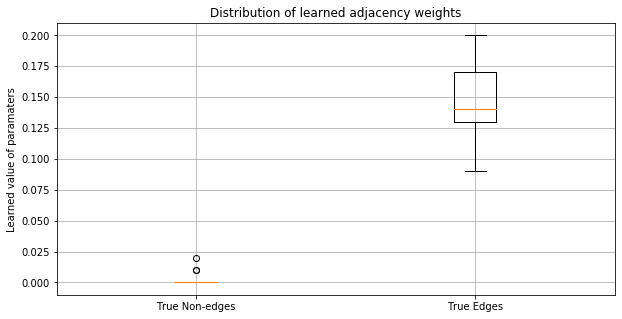

In [48]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [
        adjacency_hat[adj_true == 0.0], 
        adjacency_hat[adj_true > 0.0]
    ],
    labels=[
        'True Non-edges',
        'True Edges'
    ])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

---

## Test VI

Algorithm: Mean-Field VI with Variable $\{\beta\}$s using `WoldModelVariational`

Define the parameters of the prior.

In [78]:
dim = len(events)
# Set model
model = tsvar.models.WoldModelVariational(verbose=True)
model.observe(events)
# Set priors
# prior: Alpha
as_pr = 0.1 * np.ones((dim + 1, dim))
ar_pr = 1.0 * np.ones((dim + 1, dim))
# prior: Beta
bs_pr = 10.0 * np.ones((dim, dim))
br_pr = 10.0 * np.ones((dim, dim))
# prior: Z
zc_pr = [1.0 * np.ones((len(events[i]), dim+1)) for i in range(dim)]
# Extract ground truth (for callback, only alphas)
coeffs_true = coeffs_true_dict['adjacency'].flatten().copy()
coeffs_start = (as_pr / ar_pr)[1:, :].flatten()  # start at mean of prior of adjacency (ignore baseline)
# Set callback (parameters of callback are just the posterior mean of alpha)
callback = tsvar.utils.callbacks.LearnerCallbackMLE(
    x0=coeffs_start, print_every=PRINT_EVERY_VI,
    coeffs_true=coeffs_true, acc_thresh=0.05, dim=dim,
    default_end=CALLBACK_END)
# Fit model
conv = model.fit(as_pr=as_pr, ar_pr=ar_pr, bs_pr=bs_pr, br_pr=br_pr,
                 zc_pr=zc_pr, max_iter=VI_N_ITER, tol=VI_TOL,
                 callback=callback)


iter:    10 | dx: +3.2485e-03 | acc: 0.95 | f1-score: 0.95 | relerr: 3.28e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.92e-01     
iter:    20 | dx: +1.9276e-03 | acc: 1.00 | f1-score: 1.00 | relerr: 2.60e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.45e-01     
iter:    30 | dx: +1.4085e-03 | acc: 1.00 | f1-score: 1.00 | relerr: 2.15e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.41e-01     
iter:    40 | dx: +1.0855e-03 | acc: 1.00 | f1-score: 1.00 | relerr: 1.81e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.30e-01     
iter:    50 | dx: +8.3921e-04 | acc: 1.00 | f1-score: 1.00 | relerr: 1.56e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.31e-01     
iter:    60 | dx: +6.4608e-04 | acc: 1.00 | f1-score: 1.00 | relerr: 1.38e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.31e-01     
iter:    70 | dx: +5.4085e-04 | acc: 1.00 | f1-score: 1.00 | relerr: 1.23e-01 | p@5: 1.00 | p@10: 1.00 | p@20: 1.00 | time/it: 1.35e-01     
iter:    80 |

KeyboardInterrupt: 

In [75]:
print('\n', '='*40, type(model).__name__, '='*40, '\n')

alpha_hat_mean = model._as_po / model._ar_po

baseline_hat = alpha_hat_mean[0,:]
print('Baseline:')
print('---------')
print('Ground truth:')
print(mu.numpy())
print('Estimated:')
print(baseline_hat)
print()

adj_true = alpha.numpy()
adjacency_hat = alpha_hat_mean[1:,:]
print('Adjacency:')
print('---------')
print('Ground truth:')
print(adj_true)
print('Estimated:')
print(adjacency_hat)

THRESH = 0.05
fp = tsvar.utils.metrics.false_positive(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
fn = tsvar.utils.metrics.false_negative(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
tp = tsvar.utils.metrics.true_positive(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
tn = tsvar.utils.metrics.true_negative(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
fscore = tsvar.utils.metrics.fscore(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
relerr = tsvar.utils.metrics.relerr(adjacency_hat.flatten(), adj_true.flatten())
print('True Positive:', tp)
print('True Negative:', tn)
print('False Positive:', fp)
print('False Negative:', fn)
print('F1-Score:', fscore)
print('Relatie-Error:', relerr)
print()

print('Beta:')
print('-----')
print('...')


 ======================================== WoldModelVariational ======================================== 

Baseline:
---------
Ground truth:
[ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
Estimated:
[ 0.01  0.00  0.00  0.01  0.00  0.00  0.01  0.01  0.00  0.01]

Adjacency:
---------
Ground truth:
[[ 0.18  0.00  0.17  0.19  0.00  0.00  0.00  0.00  0.00  0.11]
 [ 0.00  0.00  0.00  0.00  0.00  0.15  0.18  0.12  0.17  0.00]
 [ 0.14  0.16  0.00  0.00  0.18  0.19  0.00  0.18  0.15  0.11]
 [ 0.00  0.00  0.00  0.00  0.16  0.00  0.00  0.00  0.00  0.18]
 [ 0.16  0.00  0.00  0.14  0.00  0.00  0.17  0.11  0.00  0.12]
 [ 0.15  0.13  0.20  0.00  0.00  0.16  0.11  0.14  0.19  0.00]
 [ 0.16  0.10  0.00  0.13  0.00  0.00  0.00  0.12  0.00  0.17]
 [ 0.00  0.14  0.00  0.11  0.11  0.00  0.15  0.11  0.00  0.00]
 [ 0.15  0.15  0.00  0.13  0.00  0.12  0.16  0.00  0.11  0.00]
 [ 0.12  0.10  0.10  0.00  0.17  0.00  0.00  0.00  0.17  0.12]]
Estimated:
[[ 0.15  0.01  0.14  0.13  0.01  0.00  0.01  0

---

## Test BG

In [76]:
import gb
import time

dim = len(events)

# Set random seed
np.random.seed(seed)

GB_N_ITER = 300

# Define model
granger_model = gb.GrangerBusca(
    alpha_prior=1.0/len(events),
    num_iter=GB_N_ITER,
    metropolis=True,
    beta_strategy='busca',
    num_jobs=1,
)
start_time = time.time()
granger_model.fit(events)
run_time = time.time() - start_time

In [77]:
adj_true = alpha.numpy()

# Extract infered adjacency
adj_hat = granger_model.Alpha_.toarray()
adj_hat = adj_hat / adj_hat.sum(axis=1)
beta_hat = np.ones((dim, dim)) * (granger_model.beta_ + 1)
coeffs_hat = np.hstack((granger_model.mu_, beta_hat.flatten(),
                        adj_hat.flatten()))

baseline_hat = alpha_hat_mean[0,:]
print('Baseline:')
print('---------')
print('Ground truth:')
print(mu.numpy())
print('Estimated:')
print(baseline_hat)
print()

adj_true = alpha.numpy()
adjacency_hat = adj_hat
print('Adjacency:')
print('---------')
print('Ground truth:')
print(adj_true)
print('Estimated:')
print(adjacency_hat)

THRESH = 0.05
fp = tsvar.utils.metrics.false_positive(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
fn = tsvar.utils.metrics.false_negative(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
tp = tsvar.utils.metrics.true_positive(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
tn = tsvar.utils.metrics.true_negative(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
fscore = tsvar.utils.metrics.fscore(adjacency_hat.flatten(), adj_true.flatten(), threshold=THRESH)
relerr = tsvar.utils.metrics.relerr(adjacency_hat.flatten(), adj_true.flatten())
print('True Positive:', tp)
print('True Negative:', tn)
print('False Positive:', fp)
print('False Negative:', fn)
print('F1-Score:', fscore)
print('Relatie-Error:', relerr)
print()


Baseline:
---------
Ground truth:
[ 0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00  0.00]
Estimated:
[ 0.01  0.00  0.00  0.01  0.00  0.00  0.01  0.01  0.00  0.01]

Adjacency:
---------
Ground truth:
[[ 0.18  0.00  0.17  0.19  0.00  0.00  0.00  0.00  0.00  0.11]
 [ 0.00  0.00  0.00  0.00  0.00  0.15  0.18  0.12  0.17  0.00]
 [ 0.14  0.16  0.00  0.00  0.18  0.19  0.00  0.18  0.15  0.11]
 [ 0.00  0.00  0.00  0.00  0.16  0.00  0.00  0.00  0.00  0.18]
 [ 0.16  0.00  0.00  0.14  0.00  0.00  0.17  0.11  0.00  0.12]
 [ 0.15  0.13  0.20  0.00  0.00  0.16  0.11  0.14  0.19  0.00]
 [ 0.16  0.10  0.00  0.13  0.00  0.00  0.00  0.12  0.00  0.17]
 [ 0.00  0.14  0.00  0.11  0.11  0.00  0.15  0.11  0.00  0.00]
 [ 0.15  0.15  0.00  0.13  0.00  0.12  0.16  0.00  0.11  0.00]
 [ 0.12  0.10  0.10  0.00  0.17  0.00  0.00  0.00  0.17  0.12]]
Estimated:
[[ 0.67  0.00  0.21  0.22  0.01  0.00  0.00  0.00  0.00  0.02]
 [ 0.00  0.39  0.00  0.00  0.00  0.16  0.28  0.08  0.11  0.00]
 [ 0.12  0.08  0.32  0.00  

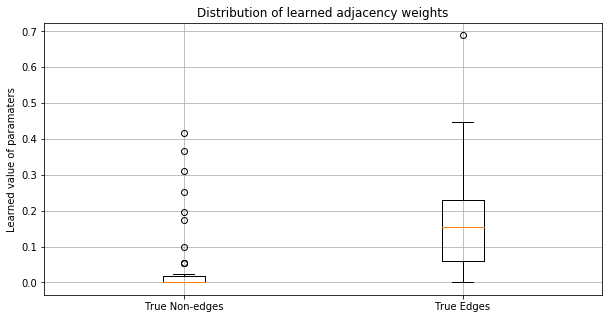

In [53]:
plt.figure(figsize=(10, 5))
plt.grid()
plt.boxplot(
    [
        adj_hat[adj_true == 0.0], 
        adj_hat[adj_true > 0.0]
    ],
    labels=[
        'True Non-edges',
        'True Edges'
    ])
plt.ylabel(r'Learned value of paramaters')
plt.title('Distribution of learned adjacency weights');

Check variation accross runs

In [ ]:
print('Diff with last call:')
print('sum:', np.sum(np.abs(adj_hat - last_adj)))
print('max:', np.max(np.abs(adj_hat - last_adj)))
print('# diff edges:', np.sum((adj_hat > 0.05) ^ (last_adj > 0.05)))
last_adj = adj_hat.copy()